<center><h1> Comment fonctionne l'impôt sur le revenu Français:<br>    
Une Notebook-Story avec OpenFisca</h1>
<h4>(Version non définitive/working paper)</h4>
<h2>Adrien Pacifico* <h5>*AMSE, THEMA, EHESS</h5></h2>
</center>

Pour parcourir ce notebook vous devez exécuter chaque cellule en appuyant sur la touche `Maj` et la touche `Enter` en même temps. 

### Installation des packages nécessaires à l'exécution du notebook.

On va commencer par installer les packages nécessaire à l'exécution du notebook, cela prend environ trente seconde, exécutez la prochaine cellule, puis continuez votre lecture le temps que les packages s'installent.

In [3]:
!pip install --upgrade pip  > /dev/null
!pip install openfisca-france > /dev/null
!pip install matplotlib > /dev/null
!pip install mpld3 > /dev/null
!pip install pandas > /dev/null
!pip install seaborn > /dev/null

1. [À propos du système socio-fiscal Français (et d'OpenFisca).](#%C3%80-propos-du-syst%C3%A8me-socio-fiscal-Fran%C3%A7ais-et-d'OpenFisca)  
2. [L'impôt sur le revenu français en théorie](#L'impôt-sur-le-revenu-français-en-théorie)
  2. [ Le barème en taux marginaux Français](#Le-barème-en-taux-marginaux-Français)  
    1. [Le barème implicite](#Le-barème-implicite)  
    2. [Calcul de l'impôt à partir du barème](#Calcul-de-l'impôt-à-partir-du-barème)   
  3. [La taxation commune en France](La-taxation-commune-en-France)  
    1.[Nombre de parts fiscales en fonction de la composition familiale](#Nombre-de-parts-fiscales-en-fonction-de-la-composition-familiale)
3. [L'impôt sur le revenu français en pratique](#L'impôt-sur-le-revenu-français-en-pratique)  
  1. [Le barème en taux marginal](#Le-barème-en-taux-marginal)  
  2. [La decote](#La-decote)  
  3. [Taux marginal effectif](#Taux-marginal-effectif)  
  4. [Perte-fiscale-au-mariage](#Perte-fiscale-au-mariage)
4. [Le plafond du quotient familial](#Le-plafond-du-quotient-familial)

# À propos du système socio-fiscal Français et d'OpenFisca

Le système socio-fiscal français pris dans une définition très large pourrait être défini par l'ensemble des règles émanant de la puissance étatique impliquant des transferts (pouvant être direct ou indirect, sous forme monétaire ou en nature) entre les différents citoyens.  
En ce sens le système socio-fiscal français est extrèmement complexe et large. 
Cela inclus évidemment les aides sociales tel que le RSA, les allocations familiales, etc. 
Cela inclu également toutes les taxes indirectes tels ques la TVA ([Taxe tampon](https://fr.wikipedia.org/wiki/Taxe_rose#Notion_de_taxe_tampon)), ou les droits d'ascise ([Taxe SODA](https://publications.banque-france.fr/publications-economiques-et-financieres-documents-de-travail/limpact-de-la-taxe-soda-sur-les-prix-des-boissons-non-alcoolisees-une-etude-sur-donnees)).
Cela va également de la gratuité des transports en commun ou d'accès à la bibliothèque pour les chômeurs porposés par beaucoup de municipalités (ce qui constitue des droits connexes locaux), à la protection maladie universelle [(PUMA)](https://www.ameli.fr/assure/droits-demarches/principes/protection-universelle-maladie), l'assistance juridictionnelle ou aux bourses CNOUS (droits connexes nationnaux).

La complexité et le nombre de règles impliquées fait qu'un modèle centralisé et fermé sera toujours incomplet pour déterminer l'effet des politiques publiques sur les transferts entre citoyens. OpenFisca permet déjà de prendre en compte une grande partie des règles du système soci-fiscal français ([OpenFisca-France](https://github.com/openfisca/openfisca-france)), mais également la taxation indirecte [Openfisca-france-indirect-taxation](https://github.com/openfisca/openfisca-france-indirect-taxation), mais aussi les aides locales de certaines villes comme [Paris](https://github.com/betagouv/openfisca-paris), Pau, [Rennes](), Brest, la région du Loiret, etc.

Sur l'ensemble de ces instruments permettant de faire des transfers entre citoyens, nous allons nous concentrer sur un instrument qui concerne environ 75 milliards d'euros parmis les 1200 milliards d'euros de recettes publiques de la France, soit environ 6,35% du budget de l'État (au sens large). Nous parlons ici de l'__impot sur le revenu__.

La version d'OpenFisca que vous utilisez est-celle qui s'affiche ci-dessous:

In [4]:
!pip show openfisca_france

Name: OpenFisca-France
Version: 23.1.1
Summary: French tax and benefit system for OpenFisca
Home-page: https://github.com/openfisca/openfisca-france
Author: OpenFisca Team
Author-email: contact@openfisca.fr
License: http://www.fsf.org/licensing/licenses/agpl-3.0.html
Location: /Users/adrienpacifico/.local/share/virtualenvs/Python_3_7_0/lib/python3.7/site-packages
Requires: OpenFisca-Core, requests
Required-by: 


### Import des packages que nous allons utiliser au cours de ce notebook

In [5]:
%matplotlib inline
from __future__ import division

In [6]:
import matplotlib.pyplot as plt, mpld3
from matplotlib.ticker import FuncFormatter
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 250)
pd.set_option('precision', 0)

Nous importons le package d'OpenFisca-France ainsi que des outils dans OpenFisca-Core :

In [7]:
#Specific usage imports
from openfisca_core import periods, rates
import openfisca_france

Nous [instancions](https://fr.wikipedia.org/wiki/Instance_(programmation)) le `tax-benefit-system` et créons des fonctions afin de simuler des scénarios (ou cas types) qui nous servirons pour les simulations.

In [8]:
tax_benefit_system = openfisca_france.FranceTaxBenefitSystem() #Instanciation

In [9]:
#Création d'une fonction pour réaliser des scénarios qui nous servions pour les simulations.
ax_variable_max = 280000
count = 1000

year_lag_max = 4
def make_scenario(couple = True, mar_pacs = True, nombre_enfants = 0, year = None, tax_benefit_system = tax_benefit_system,
                                    axes_variable = 'salaire_de_base',  ax_variable_max = ax_variable_max, ax_variable_min = 0,
                                    count = count,count_span = None, age = 12, salaire_de_base_conjoint = 0):
    if mar_pacs: assert couple == True
    if count is None: count =  (ax_variable_max - ax_variable_min)/count_span #Fais une simulation par tranche de 10 euros brut
    
    enfant = [dict(age = age)]
    enfants = enfant * nombre_enfants
    
    scenario = tax_benefit_system.new_scenario().init_single_entity(
        axes = [
            [dict(count = count, 
                  min = ax_variable_min,
                  max = ax_variable_max,
                  name = axes_variable,
                  period = year-fill_lag) for fill_lag in range(year_lag_max)]
            ],
        period = year,
        parent1 = dict(
            age = 40,
            ppe_du_sa = 6020,
            statut_marital = u"pacse",
            ) if mar_pacs else dict(
            age = 40,
            ppe_du_sa = 6020, statut_marital = u"celibataire" 
            ),
        parent2 = dict(age = 40,ppe_du_sa = 6020,statut_marital = "pacse", salaire_de_base = salaire_de_base_conjoint) if mar_pacs else (dict(age = 40,ppe_du_sa = 6020,salaire_de_base = salaire_de_base_conjoint, statut_marital = u"celibataire") if couple == True else None) ,
        enfants = enfants,
        menage = dict(
            loyer = 12000,
            statut_occupation_logement = "locataire_vide",
            depcom = 13012,
            ),
        foyer_fiscal = dict(
            f7ea = nombre_enfants * ((age<15) * age>=11), #Nombre enfants à charge poursuivants leurs études : collège
            f7ec = nombre_enfants * ((age<19) * age>=15), #Nombre enfants à charge poursuivants leurs études : lycée
            f7ef = nombre_enfants * ((age<26) * age>=19), #Nombre enfants à charge poursuivants leurs études : Enseignement supérieur
            caseT = False if couple == True else True * (nombre_enfants>0)# Warning ! TODO: mieux gérer, à priori pose pas de problème si True avec un couple marié...
            ),
        )

    if (couple == True) and (mar_pacs==False):
        test_case = scenario.test_case
        test_case["foyers_fiscaux"][0]['declarants']  = ['ind0']
        test_case["foyers_fiscaux"].append({'declarants': ['ind1'],'id': 1,'caseT': False })
        scenario.test_case = test_case
        return scenario
    else:
        return scenario
        
        


# L'impôt sur le revenu français en théorie

## Le barème en taux marginaux Français

La table ci-dessous représente le __barème fiscal en taux marginaux__ de la france pour la période 2011-2014.  
OpenFisca fonctionne en année revenu, c'est à dire que le barème affiché pour une année N correspond au barème appliqué sur les revenus de cette même année N.  
Le barème de l'impôt sur le revenu 2014, correspond donc au barème 2013 dans OpenFisca.  
Grace aux [barèmes IPP](https://www.ipp.eu/outils/baremes-ipp/) contenu dans OpenFisca il est possible en modifiant la valeur de start_year de regarder la valeur de ces taux depuis l'année 1945.

In [10]:
start_year = 2011 ; stop_year = 2019
empty_simulation = tax_benefit_system.new_scenario().new_simulation()
df = pd.DataFrame(index = range(40), columns= pd.MultiIndex.from_product([range(start_year,stop_year), ["Rate", "Threshold"]]))
for year in range(start_year, stop_year):
    parameters = empty_simulation.tax_benefit_system.parameters(year)
    df.loc[:,(year,"Rate")] = pd.Series(parameters.impot_revenu.bareme.rates)
    df.loc[:,(year,"Threshold")] = pd.Series(parameters.impot_revenu.bareme.thresholds)
    pd.options.display.float_format = '{:20,.10g}'.format

df_piecewize_scheame = df
df_piecewize_scheame.dropna(axis=0, how='all', inplace = True) ; df_piecewize_scheame.replace(np.nan, "")

2011                                      2012  \
                  Rate            Threshold                 Rate   
0                    0                    0                    0   
1                0.055                5,963                0.055   
2                 0.14               11,896                 0.14   
3                  0.3               26,420                  0.3   
4                 0.41               70,830                 0.41   
5                                                           0.45   

                                       2013                       \
             Threshold                 Rate            Threshold   
0                    0                    0                    0   
1                5,963                0.055                6,011   
2               11,896                 0.14               11,991   
3               26,420                  0.3               26,631   
4               70,830                 0.41               71,397   
5              150,000                 0.45              151,200   

                  2014                                      2015  \
                  Rate            Threshold                 Rate   
0                    0                    0                    0   
1                 0.14                9,690                 0.14   
2                  0.3               26,764                  0.3   
3                 0.41               71,754                 0.41   
4                 0.45              151,956                 0.45   
5                                                                  

                                       2016                       \
             Threshold                 Rate            Threshold   
0                    0                    0                    0   
1                9,700                 0.14                9,710   
2               26,791                  0.3               26,818   
3               71,826                 0.41               71,898   
4              152,108                 0.45              152,260   
5                                                                  

                  2017                                      2018  \
                  Rate            Threshold                 Rate   
0                    0                    0                    0   
1                 0.14                9,807                 0.14   
2                  0.3               27,086                  0.3   
3                 0.41               72,617                 0.41   
4                 0.45              153,783                 0.45   
5                                                                  

                        
             Threshold  
0                    0  
1                9,807  
2               27,086  
3               72,617  
4              153,783  
5

### Le barème implicite

Certains méchanismes fiscaux comme la *contribution exceptionnelle sur les hauts revenus* (cehr) (ou *la décote*) ajoutent des __tranches implicites__ au barème de l'impôt qui ne respectent pas totalement la logique du quotient familial.

Voici le barème une fois les tranches implicites dues à la *cehr* sont intégrées.

In [11]:
start_year = 2010 ; stop_year = 2019
empty_simulation = tax_benefit_system.new_scenario().new_simulation()
df = pd.DataFrame(index = range(40), columns= pd.MultiIndex.from_product([range(start_year,stop_year), ["Rate", "Threshold"]]))
df_cehr = df.copy()
for year in range(start_year, stop_year):
    parameters = empty_simulation.tax_benefit_system.parameters(year)
    thresholds = np.array(parameters.impot_revenu.bareme.thresholds)
    thresholds_with_cehr = np.append(thresholds, parameters.impot_revenu.cehr.thresholds[1:]) #TODO: faire ça proprement, ajouter la décote
    
    rates = np.array(parameters.impot_revenu.bareme.rates)
    rates_with_cehr = np.append(rates, rates[-1]+parameters.impot_revenu.cehr.rates[1:])
    df_cehr.loc[:,(year,"Rate")] = pd.Series(rates_with_cehr)
    df_cehr.loc[:,(year,"Threshold")] = pd.Series(thresholds_with_cehr)
    pd.options.display.float_format = '{:20,.10g}'.format

df_cehr.dropna(axis=0, how='all', inplace = True) ; df_cehr.replace(np.nan, "")

2010                                      2011  \
                  Rate            Threshold                 Rate   
0                    0                    0                    0   
1                0.055                5,963                0.055   
2                 0.14               11,896                 0.14   
3                  0.3               26,420                  0.3   
4                 0.41               70,830                 0.41   
5                                                           0.44   
6                                                           0.45   
7                                                                  

                                       2012                       \
             Threshold                 Rate            Threshold   
0                    0                    0                    0   
1                5,963                0.055                5,963   
2               11,896                 0.14               11,896   
3               26,420                  0.3               26,420   
4               70,830                 0.41               70,830   
5              250,000                 0.45              150,000   
6              500,000                 0.48              250,000   
7                                      0.49              500,000   

                  2013                                      2014  \
                  Rate            Threshold                 Rate   
0                    0                    0                    0   
1                0.055                6,011                 0.14   
2                 0.14               11,991                  0.3   
3                  0.3               26,631                 0.41   
4                 0.41               71,397                 0.45   
5                 0.45              151,200                 0.48   
6                 0.48              250,000                 0.49   
7                 0.49              500,000                        

                                       2015                       \
             Threshold                 Rate            Threshold   
0                    0                    0                    0   
1                9,690                 0.14                9,700   
2               26,764                  0.3               26,791   
3               71,754                 0.41               71,826   
4              151,956                 0.45              152,108   
5              250,000                 0.48              250,000   
6              500,000                 0.49              500,000   
7                                                                  

                  2016                                      2017  \
                  Rate            Threshold                 Rate   
0                    0                    0                    0   
1                 0.14                9,710                 0.14   
2                  0.3               26,818                  0.3   
3                 0.41               71,898                 0.41   
4                 0.45              152,260                 0.45   
5                 0.48              250,000                 0.48   
6                 0.49              500,000                 0.49   
7                                                                  

                                       2018                       
             Threshold                 Rate            Threshold  
0                    0                    0                    0  
1                9,807                 0.14                9,807  
2               27,086                  0.3               27,086  
3               72,617                 0.41               72,617  
4              153,783                 0.45              153,783  
5              250,000                 0.48              250,000  
6              500,000                 0.49              500,000  
7

D'autres prestations implicites pourraient être ajoutées à ce barème, mais qui ne respecteraient plus la logique du quotient familial.

## Calcul de l'impôt à partir du barème


La France, comme la plupart des pays (à l'exception notable par exemple de l'Allemagne) utilise un impôt qui est une fonction linéaire par morceaux.


Un impôt linéaire par morceau est défini par:
 1. Une séquence de taux marginaux (habituellement croissante).
 $$0<m_0 <m_1 <...<m_p$$ 
 2. Et les seuils qui définissent sur quelle partie du revenu imposable un spécifique taux s'applique.
 $$0= \beta_0<\beta_1< ... < \beta_n  $$

Ceci sont les informations qui sont données par le *barème de l'impôt sur le revenu* que nous avons montré ci-dessus.  

Si un foyer fiscal a un revenu taxable $y \in [\beta_k,\beta_{k+1}]$, alors sont impôt sur le revenu sera:
$$s(y)=   \sum_{j \leq k-1} mj(\beta{j+1} − \beta{j})+m_k(y−\beta_j)$$


<h1><center>
   </center></h1>

(Formalisation d'un barème par morceaux prise dans P.J. "Lambert The distribution and redistribution of income", third edition P.181)

Cependant cette formule ne s'applique que pour les couples célibataires sans enfants, la France à un régime particulier pour prendre en compte l'équité horizontale : **le quotient familial**. 

## La taxation commune en France

En France les couples sous union civile (i.e. soit mariés, soit pacés), font normalement l'objet d'une imposition commune de leurs revenu.  

Cette imposition commune consiste à :  

1. Regrouper les revenus de tout les individus du foyer fiscal (enfants et autre personnes à charges incluses).
2. Diviser ce revenu par le nombre de parts fiscales (voir section suivante).
3. Appliquer le barème linéaire par morceaux de l'impôt sur le revenu.
4. Remultiplier ce résultat par le nombre de parts fiscales



 

Formellement:  
<h1><center>$T(\frac{\sum{y_i}}{\text{Parts Fiscales}}) \times \text{Parts Fiscales} $  </center></h1>
Où $T()$ est la fonction linéaire par morceaux de l'impôt sur le revenu et $y_i$ est le revenu d'un individu i appartenant au foyer fiscal.

Le système amenant à diviser le revenu par le nombre de parts fiscales avant d'y appliquer le barème est appelé système du quotient familial. 
Il comporte une notion de sacrifice égal, c'est à dire qu'il suit une forme de logique proche des [échelles d'équivalences]().

Le revenu divisé par le nombre de parts fiscales est appelé par l'administration le revenu mis au **quotient familial**, ou quotient familial. Certains économistes parlent [de revenu equivalent](https://www.ccomptes.fr/sites/default/files/EzPublish/20150204-rapport-particulier-Bargain.pdf) pour faire référence au rapport aux échelles d'équivalences impliqué par l'impôt sur le revenu, d'autres parlent [d'échelles d'équivalences politiques](https://www.ofce.sciences-po.fr/pdf/dtravail/WP2015-16.pdf).

Il est à noter qu'il existe un méchanisme de limitation de l'avantage fiscal lié aux parts fiscales des enfants appelé **plafond du quotient familial** qui concerne les ménages dans le dernier décile de revenu. Par souci de concision, ce méchanisme ne sera pas traité au sein de ce notebook.

## Nombre de parts fiscales en fonction de la composition familiale

In [61]:
simulation_dict_couple_union_libre = dict()
for nb_enf in range(0,6):
    simulation_dict_couple_union_libre[nb_enf] = dict()
    for year in range(2015,2016): 
        simulation_dict_couple_union_libre[nb_enf][year] = make_scenario(couple = True,mar_pacs=False,nombre_enfants=nb_enf,year = year, count= 1).new_simulation()
simulation_dict_couple_mar_pacs = dict()
for nb_enf in range(0,6):
    simulation_dict_couple_mar_pacs[nb_enf] = dict()
    for year in range(2015,2016): 
        simulation_dict_couple_mar_pacs[nb_enf][year] = make_scenario(couple = True,mar_pacs=True,nombre_enfants=nb_enf,year = year, count= 1).new_simulation()
simulation_dict_single = dict()
for nb_enf in range(0,6):
    simulation_dict_single[nb_enf] = dict()
    for year in range(2015,2016): 
        simulation_dict_single[nb_enf][year] = make_scenario(couple = False, mar_pacs=False, nombre_enfants=nb_enf,year = year, count=1).new_simulation()

In [62]:
df = pd.DataFrame(index = range(6))
for nb_enf in range(0, 6):
    df.loc[nb_enf,u"En couple(marié ou pacsé)"] = simulation_dict_couple_mar_pacs[nb_enf][2015].calculate("nbptr", period = "2015")[0]
    df.loc[nb_enf,u"Union libre"] = simulation_dict_couple_union_libre[nb_enf][2015].calculate("nbptr", period = "2015")[0]
    df.loc[nb_enf,u"Célibataire"] = simulation_dict_single[nb_enf][2015].calculate("nbptr", period = "2015")[0]
    pd.options.display.float_format = '{:20,.10g}'.format
    df.index.name = "Enfants"

In [63]:
df

,En couple(marié ou pacsé),Union libre,Célibataire
Enfants,,,
0,2,1,1
1,2.5,1.5,2
2,3,2,2.5
3,4,3,3.5
4,5,4,4.5
5,6,5,5.5


La table ci-dessus montre le nombre de part fiscale pour un foyer fiscal pour un couple sous union-civile, pour un célibataire (au sens de l'impôt) vivant en couple, et pour un célibataire en fonction du nombre d'enfants dans le foyer fiscal. 

Il existe d'autres situations fiscales particulières (parents ou grands parents habitant sous le même toit, enfants handicapés, etc) pouvant modifier le nombre de parts fiscales.



##### Parts fiscales par ménage

Cependant un couple qui n'est pas sous union civile est constitué de deux foyers fiscaux, si on somme les parts de chaque foyer fiscal sur le ménage, on obtient le tableau suivant.

In [64]:

year = 2016
df = pd.DataFrame(index = range(6))
for nb_enf in range(0, 6):
    for simul_name, simulation_by_child_by_year in {u"En couple(marié ou pacsé)":simulation_dict_couple_mar_pacs,
                                  u"Union libre":simulation_dict_couple_union_libre,
                                  u"Célibataire":simulation_dict_single}.items():
        simul = simulation_by_child_by_year[nb_enf][2015]
        nbptr = simul.calculate("nbptr", period = "2015")
        projected_nbptr =  simul.foyer_fiscal.project_on_first_person(nbptr)
        summed_over_menage_nbptr = simul.menage.sum(projected_nbptr)
        df.loc[nb_enf,simul_name] = summed_over_menage_nbptr
    pd.options.display.float_format = '{:20,.10g}'.format
    #df[year]["Rates"] = parameters.impot_revenu.bareme.rates
    df.index.name = "Enfants"

In [65]:
df

,En couple(marié ou pacsé),Union libre,Célibataire
Enfants,,,
0,2,2,1
1,2.5,2.5,2
2,3,3,2.5
3,4,4,3.5
4,5,5,4.5
5,6,6,5.5


On a le même nombre de parts fiscales sur le ménage entre un couple marié et un couple en union libre. Mais ceci ne vaut que si l'on met tout les enfants dans le même foyer fiscal. À cause de la part supplémentaire (au lieu de la demie-part) à partir du 3ème enfant, un ménage peut avoir plus ou moins de parts fiscales en fonction du choix d'allocation des enfants entre les deux foyers fiscaux.  

# L'impôt sur le revenu français en pratique

## Le barème en taux marginal

On va regarder dans un premier temps l'action du barème de l'impôt sur le revenu d'un célibataire, pour cela on lance une simulation en faisant varier le montant du salaire pour un célibataire.

In [66]:
simulation_no_child = make_scenario(couple = False, mar_pacs=False,nombre_enfants=0,year = 2016, ax_variable_min=0, ax_variable_max=250000).new_simulation()

In [67]:
salaire_imposable = simulation_no_child.calculate_add("salaire_imposable", period = 2016)
rni = simulation_no_child.calculate_add("rni", period = 2016)
impot_brut = simulation_no_child.calculate("ir_brut", period = 2016)

Nous allons nous intéresser dans un premier temps à une seule observation de notre simulation, la 301 ème.

In [68]:
print(salaire_imposable[300]) #301 ème observation, en python l'indexation des vecteurs démarrent à 0.
print("Salaire imposable :", simulation_no_child.calculate_add("salaire_imposable", period = 2016)[300])
print("Revenu fiscal de référence :", simulation_no_child.calculate_add("rfr", period = 2016)[300]) #
print("Impôt sur le revenu :", impot_brut[300]) 

61235.703
Salaire imposable : 61235.703
Revenu fiscal de référence : 55111.703
Impôt sur le revenu : 10883.23


Ci-dessus le résultat obtenu pour la 301 entité de notre simulation correspondant à un célibataire gagnant 61235 euros de salaire imposable , ayant un revenu fiscal de référence de 55111 euros (il existe un abbatement de 10% pour les salariés, voir plus bas), et dont l'impôt calculté par OpenFisca est évalué a 10883 euros.

Nous pouvons comparer les résultats obtenu avec Openfisca avec une simulation réalisé sur le site des impot ( [www.impots.gouv.fr](https://www3.impots.gouv.fr/simulateur/calcul_impot/2018/index.htm)). Pour l'impôt correspondant aux revenus 2016 qui est donné par OpenFisca, il faut utiliser le simulateur de [l'année 2017](https://www3.impots.gouv.fr/simulateur/calcul_impot/2017/index.htm).



<img src="./simulateur_dgfip.png">

On peut voir que le résultat est le même dans le simulateur des impôt et dans la simulation réalisée par OpenFisca.

Nous pouvons aussi faire un graphique de l'ensemble des simulations ordonné en fonction du salaire net:

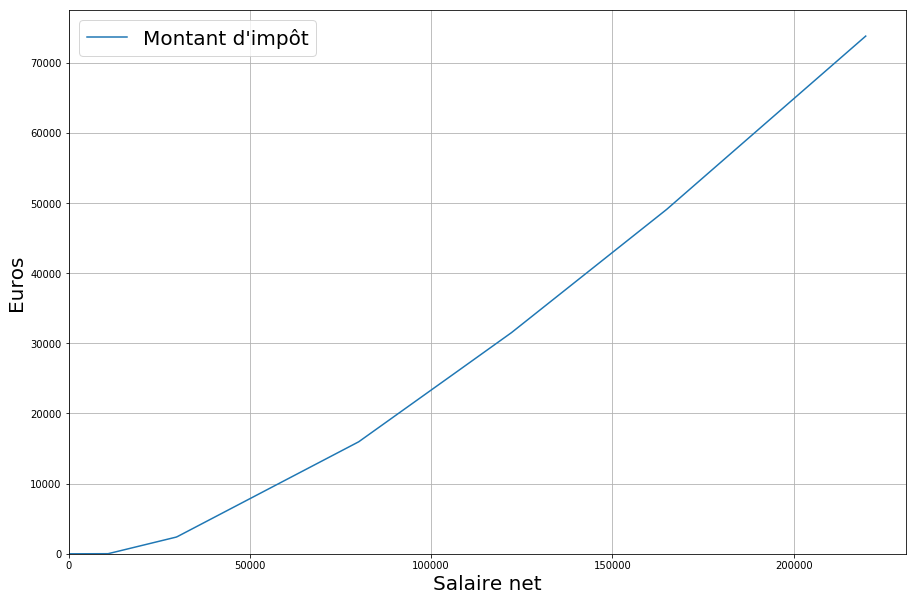

In [20]:
%matplotlib inline
plt.figure(figsize=(15,10))
plt.plot(salaire_imposable, impot_brut, label = u"Montant d'impôt")
plt.legend( fontsize = 20); plt.xlabel("Salaire net", fontsize = 20); plt.ylabel("Euros", fontsize = 20); plt.xlim(0); plt.ylim(0); plt.grid()

Le graphs ci-dessus montre le montant qui est payé en euros pour un salaire net donné.

Mais il est aussi possible de retrouver, à partir de la fonction d'impôt, le barème, en prennant sa dérivée (ici approximé par son taux de variation $\frac{f(y_{i+1})-f(y_i)}{y_i - y_{i+1}}$, où $y_i$ est le i ème élément du vecteur revenu et $f(.)$ la fonction d'impôt).

/Users/adrienpacifico/.local/share/virtualenvs/Python_3_7_0/lib/python3.7/site-packages/openfisca_core/rates.py:15: RuntimeWarning: invalid value encountered in true_divide
  marginal_rate = 1 - (target[:-1] - target[1:]) / (varying[:-1] - varying[1:])


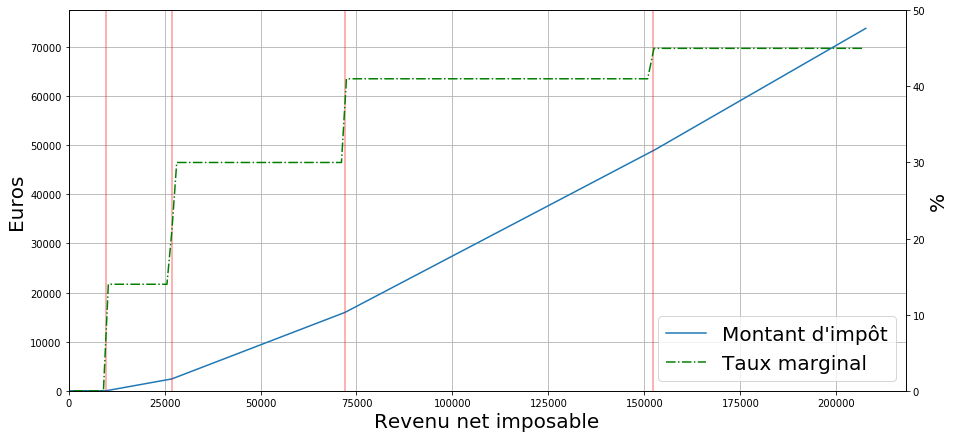

In [21]:
fig = plt.figure(figsize=(15,7)); from openfisca_core import rates

### Graph
smooth = 7
ax = fig.add_subplot(1,1,1) 
ax2 = ax.twinx()
lns1 = ax.plot(rni, 
        impot_brut, label = u"Montant d'impôt")
lns2 = ax2.plot(rni[1::smooth],
        (1-rates.marginal_rate(
                           impot_brut,rni)[::smooth])*100, linestyle = "-.", color = "g", label = "Taux marginal")
for val in df_piecewize_scheame[2016]["Threshold"]: 
    plt.vlines(val, 0,50, color = 'r', alpha = .4)
    
##### Customisation cosmétique du graphique    
    
ax.set_xlim(0); ax.set_ylim(0); ax2.set_ylim(0,50); ax.grid()
ax.set_xlabel("Revenu net imposable", fontsize = 20); ax.set_ylabel("Euros", fontsize = 20); ax2.set_ylabel(u"%", fontsize = 20);
#ax.legend(fontsize = 20, loc = 4); ax2.legend(fontsize = 20, loc = 4) 

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=4, fontsize = 20)


En on voit bien ici le barème de l'impôt sur le revenu avec les 4 premières tranches de l'impôt sur le revenu (courbe "dashdotted" verte).  

En allant chercher les seuils du barème 2016 issu des paramètres Openfisca (contenu dans `df_piecewize_scheame[2016]["Threshold"]`), représenté par les barres verticales rouges, ont voit que les taux marginaux issu de la dérivée de la fonction suivent effectivement les seuils qui sont entrés en paramètres dans OpenFisca.

/Users/adrienpacifico/.local/share/virtualenvs/Python_3_7_0/lib/python3.7/site-packages/openfisca_core/rates.py:15: RuntimeWarning: invalid value encountered in true_divide
  marginal_rate = 1 - (target[:-1] - target[1:]) / (varying[:-1] - varying[1:])


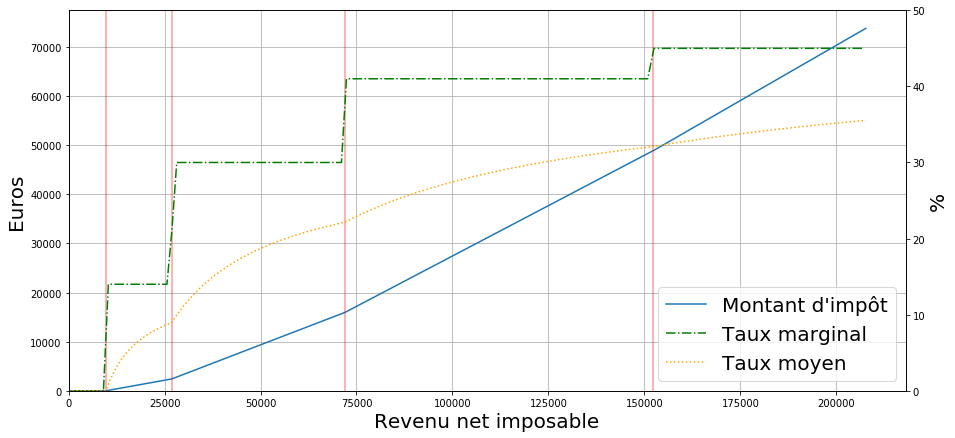

In [58]:
fig = plt.figure(figsize=(15,7))

### Graph
smooth = 7
ax = fig.add_subplot(1,1,1) 
ax2 = ax.twinx()
lns1 = ax.plot(rni, 
        impot_brut, label = u"Montant d'impôt")
lns2 = ax2.plot(rni[1::smooth],
        (1-rates.marginal_rate(
                           impot_brut,rni)[::smooth])*100, linestyle = "-.", color = "g", label = "Taux marginal")
lns3 = ax2.plot(rni,
        (1-rates.average_rate(
                           impot_brut,rni))*100, linestyle = ":", color = "orange", label = "Taux moyen")
for val in df_piecewize_scheame[2016]["Threshold"]: 
    plt.vlines(val, 0,50, color = 'r', alpha = .4)
    
##### Customisation cosmétique du graphique    
    
ax.set_xlim(0); ax.set_ylim(0); ax2.set_ylim(0,50); ax.grid()
ax.set_xlabel("Revenu net imposable", fontsize = 20); ax.set_ylabel("Euros", fontsize = 20); ax2.set_ylabel(u"%", fontsize = 20);
#ax.legend(fontsize = 20, loc = 4); ax2.legend(fontsize = 20, loc = 4) 

lns = lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=4, fontsize = 20)


Il est courrant de voir les gens confondre le taux marginal et le taux moyen d'impôt, il n'y a qu'à ce souvenir de certaines réaction de citoyen dans les médias lors de l'annonce de l'introduction de la taxe à 75%.<sup><a href="#fn1" id="ref1">1</a></sup> 


 * **Le taux marginal** donne le montant d'impôt supplémentaire pour une augmentation petite augmentation ( une augmentation "marginale") du revenu. Par exemple un foyer fiscal gagne 100 euros de plus, et que son impôt supplémentaire est de 30 euros, alors ce foyer fiscal fait face à un taux marginal de 30%. Pour un changement marginal de 100 euros, il peut être calculé suivant la formule suivante $\frac{f(y+100)-f(100)}{(y +100) - y}$ ou y est le revenu imposable.
 
 * **Le taux moyen** donne le montant moyen d'impôt pour une revenu imposable donné. Par exemple un foyer fiscal ayant un revenu imposable de 55112 euros et payant 10883 euros d'impôt (il s'agit là du 301 ème foyer fiscal de notre simulation). Son taux moyen ne sera que de 19,7% (qu'on retrouve en faisant $\frac{10883}{55112}$). 

Le taux moyen est normalement toujours inférieur au taux marginal.<sup><a href="#fn2" id="ref2">2</a></sup>

<hr></hr>

<sup id="fn1">1. Qui aura finalement été annulée par le conseil constitutionnel, puis réintroduit sous une autre forme, voir [Guillot (2018)](https://afse2018.sciencesconf.org/191247/document) pour une évaluation de la réforme, ou [ici](https://www.2isf.org/de-limpot-confiscatoire-a-limpot-confisque/) pour un contexte plus juridique.<a href="#ref1" title="Jump back to footnote 1 in the text.">↩</a></sup><br>
<sup id="fn2">2. Pour que le taux moyen soit supérieur au taux marginal, il faudrait soit qu'il existe une [Poll tax](https://fr.wikipedia.org/wiki/Poll_tax), ou alors que l'impôt soit à un endroit très fortement régressif/qu'il y ait un endroit ou les taux marginaux soit fortement décroissant dans le barème.<a href="#ref2" title="Jump back to footnote 2 in the text.">↩</a></sup>

In [23]:
print("Taux moyen de l'individu 301 : ",((1-rates.average_rate(impot_brut,rni))*100)[300])
print("Taux marginal de l'individu 301 : ",((1-rates.marginal_rate(
                           impot_brut,rni))*100)[300])

Taux moyen de l'individu 301 :  19.747585
Taux marginal de l'individu 301 :  30.00021


/Users/adrienpacifico/.local/share/virtualenvs/Python_3_7_0/lib/python3.7/site-packages/openfisca_core/rates.py:15: RuntimeWarning: invalid value encountered in true_divide
  marginal_rate = 1 - (target[:-1] - target[1:]) / (varying[:-1] - varying[1:])


### La decote

La décote est un méchanisme fiscal qui vise à exonhérer d'impôt une grande partie de la population. Mais elle introduit une tranche fiscale implicite égale à deux fois le taux marginal de la première tranche, ce qui mêne une grande partie des français fait en fait face à un barème de l'impôt sur le revenu régressif plutôt que progressif. Une description plus poussée destinée à un public généraliste peut être trouvée dans [la note IDEP Analyses N°7](https://www.idep-fr.org/sites/default/files/idep/idep_analyses_n7.pdf).

La formule générale de la décote est la suivante:

$$\text{Décote} = max(\text{Seuil de la décote} - (\text{Impôt sur le revenuavant décote} \times \text{coefficient}), 0)$$.

Ainsi celle-ci est constituée en quatre partie:
 1. Une partie où elle n'a pas d'effet, car le foyer fiscal est non imposable. 
 2. Une partie où elle a un effet exhonérateur, c'est-à-dire qu'en l'absence de décote, le foyer fiscal paierait de l'impôt.
 [comment]: <> (  Plus formellement quand : $$\text{Seuil de la décote} - (\text{Impôt sur le revenu avant décote} \times \text{coefficient})<0$$)
  
 3. Une partie où elle a un effet réducteur de l'impôt.
 4. Et une partie ou elle n'a plus d'effet quand le foyer fiscal est assez riche.



Le seuil de la décote en 2016 sont:

Pour une célibataire:

In [85]:
simulation_no_child.tax_benefit_system.parameters(2016).impot_revenu.decote.seuil_celib

1165.0

Pour un couple:

In [88]:
simulation_no_child.tax_benefit_system.parameters(2016).impot_revenu.decote.seuil_couple

1920.0

Le coefficient n'est pour l'instant pas intégré en tant que paramètre dans OpenFisca (il est codé en dur dans la formule en fonction de l'année), pour l'année 2016, celui-ci est de 1.

In [89]:
decote_gain_fiscal = simulation_no_child.calculate("decote_gain_fiscal", year)

Text(0,0.5,'Gain fiscal de la décote en euros')

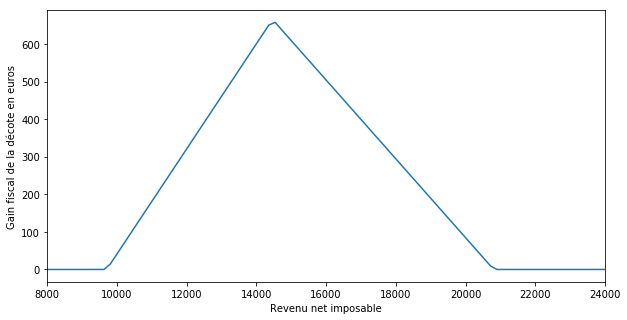

In [90]:
plt.figure(figsize=(10,5))
plt.plot(rni,decote_gain_fiscal); plt.xlim(8000,24000); plt.xlabel("Revenu net imposable", ); plt.ylabel("Gain fiscal de la décote en euros")

Le graphique ci-dessus montre bien ces 4 parties, la permière de 0 à 9632 euros de revenu net imposable (9700 dans les faits -- première tranche de l'IR--, ceci est du au fait que notre simulation se fait par tranches de 200 euros), puis l'effet exhonérateur agit jusqu'au sommet de la courbe aux alentours de 14 600 euros pour un gain fiscal lié à la décote de 658 euros, puis l'extinction de la décote aux alentours de 20 000 euros.

In [91]:
salaire_imposable[11] - salaire_imposable[10]

201.91797

In [92]:
gain_fiscal_max_decote = np.max(decote_gain_fiscal); print("Gain fiscal maximum du à la décote : ", np.round(gain_fiscal_max_decote, 2), "€")


Gain fiscal maximum du à la décote :  657.95 €


In [93]:
end_of_decote_idx = (np.where(decote_gain_fiscal[np.argmax(decote_gain_fiscal):]==0)+np.argmax(decote_gain_fiscal))[0][0] #indices_of_null_value_greater_than_max
start_of_decote_idx = (np.where(decote_gain_fiscal[:np.argmax(decote_gain_fiscal)]==0))[0][-1] #indices_of_null_value_greater_than_max
rni_start_of_decote = rni[start_of_decote_idx]; print("Début de la décote :\n",rni_start_of_decote, " €")
idx_gain_fiscal_max_decote = np.argmax(decote_gain_fiscal)
rni_at_max_decote = rni[np.argmax(decote_gain_fiscal)]; print("Début de l'imposabilité, gain maximum de la décote : \n", 
                                  np.round(rni_at_max_decote,2), "€")
rni_end_of_decote = rni[end_of_decote_idx]; print("Fin de la décote :\n",np.round(rni_end_of_decote,2), "€")

Début de la décote :
 9632.034  €
Début de l'imposabilité, gain maximum de la décote : 
 14539.01 €
Fin de la décote :
 20899.38 €


### Effet de la décote sur les taux marginaux.

/Users/adrienpacifico/.local/share/virtualenvs/Python_3_7_0/lib/python3.7/site-packages/openfisca_core/rates.py:15: RuntimeWarning: invalid value encountered in true_divide
  marginal_rate = 1 - (target[:-1] - target[1:]) / (varying[:-1] - varying[1:])


(0, 0.5)

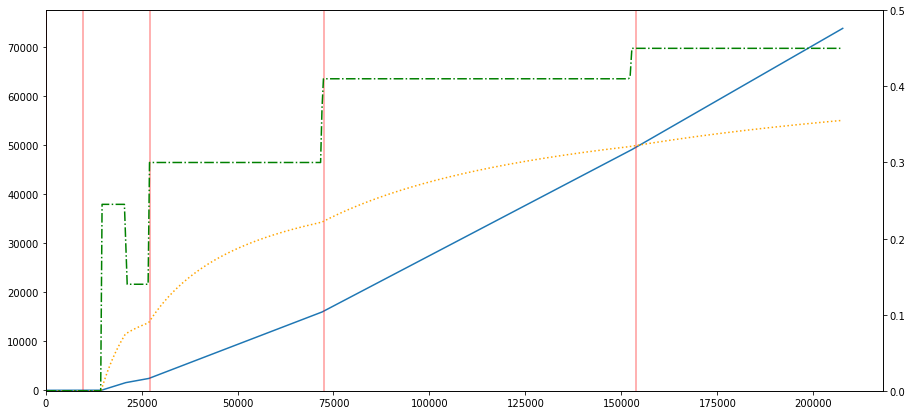

In [70]:
impot_sur_le_revenu_avant_reductions = (
    simulation_no_child.calculate("ip_net", 2016) 
    + simulation_no_child.calculate("reduction_ss_condition_revenus",2016).clip(0) # On tweeke ici un petit peu OpenFisca pour ne pas prendre en compte la réduction d'impôt sous condition de revenus, voir https://github.com/openfisca/openfisca-france/issues/1204 
)

fig = plt.figure(figsize=(15,7))
smooth = 2
ax = fig.add_subplot(1,1,1) 
ax2 = ax.twinx()
ax.plot(rni, 
        impot_sur_le_revenu_avant_reductions)
ax2.plot(rni,
        1-rates.average_rate(
                           impot_sur_le_revenu_avant_reductions,rni), linestyle = ":", color = "orange")
ax2.plot(rni[1::smooth],
        1-rates.marginal_rate(
                           impot_sur_le_revenu_avant_reductions,rni)[::smooth], linestyle = "-.", color = "g")
for val in df_piecewize_scheame[2017]["Threshold"]: 
    plt.vlines(val, 0,0.5, color = 'r', alpha = .4)
ax.set_xlim(0); ax.set_ylim(-100); ax2.set_ylim(0,.5)

L'effet principal de la décote sur les taux marginaux est de multiplier par deux ($1+ \text{coefficient}$) le taux marginal qui devrait s'appliquer en l'absence de décote.<sup><a href="#fn1" id="ref1">1</a></sup>  

Il en résulte pour 2016 une tranche implicite à 28% (2 fois 14%). Il est donc possible d'intégrer la décote au barème implicite de l'impôt sur le revenu du célibataire.


<hr></hr>

<sup id="fn1">1. Soit entendu une fois que l'effet exhonérateur s'est éteint. Avant que la partie "reduction de l'impôt" soit atteinte, l'effet sur le taux marginal est simplement de le rammener à 0%.<a href="#ref1" title="Jump back to footnote 1 in the text.">↩</a></sup><br>

##### Barème implicite comprenant la décote

Nous pouvons maintenant inclure le barème implicite auquel fait face un célibataire en incluant la décote de l'impôt sur le revenu.  
Ce même barème implicite peut facilement être obtenu pour différentes structures familiales en appliquant la même méthodologie que pour le célibataire en modifiant légèrement ce notebook.

Repartons du barème implicite qui inclu la CEHR, et ajoutons lui la tranche implicite contenant la décote.

In [106]:
df_decote = df_cehr.copy()[2016]

In [107]:
print(rni_start_of_decote)
print(rni_at_max_decote)
print(rni_end_of_decote)

9632.034
14539.009
20899.377


In [108]:
df_decote.index = np.concatenate((df_decote.index[:2], df_decote.index[2:] +1)) #on décale les tranche pour laisser une palce à la tranche implicite
df_decote.loc[1] = [0.14*2,np.round(rni_at_max_decote)]#Fin de la tranche implicite, retour sur tranche normale]
df_decote.loc[2]= [0.14, np.round(rni_end_of_decote)]

In [109]:
df_decote.sort_index().dropna()

,Rate,Threshold
0,0,0
1,0.28,"14,539"
2,0.14,"20,899"
3,0.3,"26,818"
4,0.41,"71,898"
5,0.45,"152,260"
6,0.48,"250,000"
7,0.49,"500,000"


Nous avons donc le barème implicite de l'impôt en 7 tranches de l'impôt sur le revenu du célibataire.

## Evolution de la décote au cours du temps.

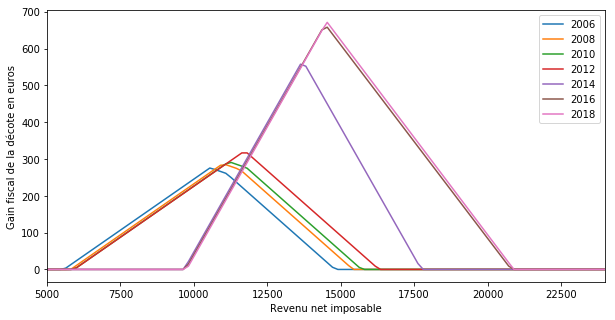

In [113]:
plt.figure(figsize=(10,5))
for year in range(2006, 2019,2):
    simulation_temp_decote = make_scenario(couple = False, mar_pacs=False,nombre_enfants=0,year = year, ax_variable_min=0, ax_variable_max=250000).new_simulation()
    decote_gain_fiscal = simulation_temp_decote.calculate("decote_gain_fiscal", year)
    plt.plot(rni,decote_gain_fiscal, label = year); plt.xlim(5000,24000); plt.xlabel("Revenu net imposable", ); plt.ylabel("Gain fiscal de la décote en euros")
plt.legend()

Le graphique ci-dessus représente le gain fiscal à la décote de 2006 à 2018.<sup><a href="#fn1" id="ref1">1</a></sup> On peut voir que l'avantage fiscal lié à la décote ne fait que augmenter. Dans les faits la décote à été introduite en 1981 et son effet n'a cessé d'être renforcé depuis par les gouvernements succéssifs. Cela est étudié dans un modèle théorique d'économie politique ([Bierbrauer &al ()2018](https://lagv2018.sciencesconf.org/192863/document)) qui s'appuie sur l'évolution de la décote au cours du temps pour illustrer leurs propos. 
<hr></hr>

<sup id="fn1">1. Dans un souci de lisibilité, le graphique ci-dessus graphe la décote uniquement une année sur deux.<a href="#ref1" title="Jump back to footnote 1 in the text.">↩</a></sup><br>

### Differents taux marginaux

Les revenus nets bénéficient d'une série de potentiels abatements qui vont constituer la base taxable.  
Un abatement important est l'abbatement de 10% dit pour frais professionel (ou le choix d'être au frais réels (case 1AK).

Cela conduit à des taux effectifs de taxations différent des taux affichés dans le barème de l'impôt sur le revenu.

In [90]:
salaire_net = simulation_no_child.calculate_add("salaire_net", 2016)
salaire_de_base = simulation_no_child.calculate_add("salaire_de_base", 2016)
salaire_super_brut = simulation_no_child.calculate_add("salaire_super_brut", 2016)
revenu_disponible = simulation_no_child.calculate_add("revenu_disponible", 2016)


/Users/adrienpacifico/.local/share/virtualenvs/Python_3_7_0/lib/python3.7/site-packages/openfisca_core/rates.py:15: RuntimeWarning: invalid value encountered in true_divide
  marginal_rate = 1 - (target[:-1] - target[1:]) / (varying[:-1] - varying[1:])


Text(0,0.5,'Euros')

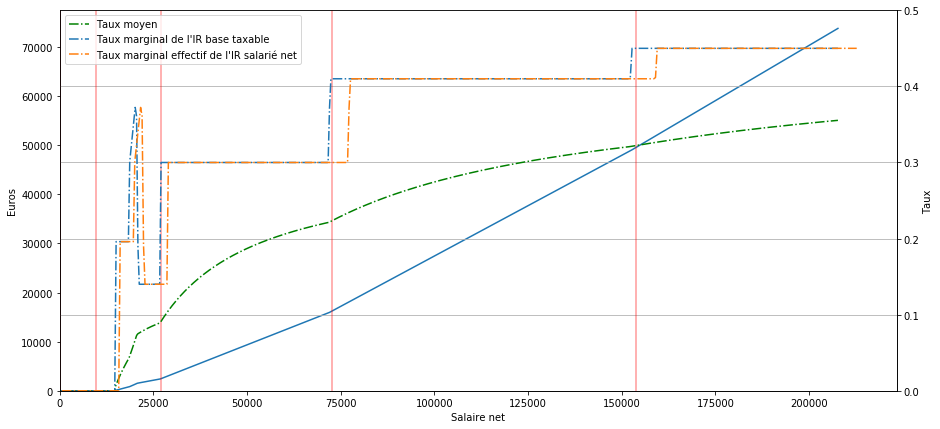

In [31]:
fig = plt.figure(figsize=(15,7))
smooth = 2
ax = fig.add_subplot(1,1,1) 
ax2 = ax.twinx()
ax.plot(rni, 
        impot_total_sur_le_revenu, label = 'Impot')
ax2.plot(rni,
        1-rates.average_rate(
                           impot_total_sur_le_revenu,rni), linestyle = "-.", color = "g", label = "Taux moyen")

ax2.plot(rni[1::smooth],
        1-rates.marginal_rate(
                           impot_total_sur_le_revenu,rni)[::smooth], linestyle = "-.", label = "Taux marginal de l'IR base taxable")
ax2.plot(salaire_net[1::smooth],
        1-rates.marginal_rate(
                           impot_total_sur_le_revenu,rni)[::smooth], linestyle = "-.", label = u"Taux marginal effectif de l'IR salarié net")
#ax2.plot(salaire_net[1::smooth],
#        1-rates.marginal_rate(
#                           impot_total_sur_le_revenu,salaire_de_base)[::smooth], linestyle = "-.", color = "k", label = "Taux marginal de l'IR base salaire brut")
#ax2.plot(salaire_net[1::smooth],
#        1-rates.marginal_rate(
#                           impot_total_sur_le_revenu,salaire_super_brut)[::smooth], linestyle = "-.", color = "r", label = "Taux marginal de l'IR base salaire super brut")

for val in df_piecewize_scheame[2017]["Threshold"]: 
    plt.vlines(val, 0,0.5, color = 'r', alpha = .4)
ax.set_xlim(0); ax.set_ylim(0); ax2.set_ylim(0,.5); plt.legend(); plt.grid(); ax.set_xlabel("Salaire net"); ax2.set_ylabel("Taux") ; ax.set_ylabel("Euros")

On voit que cela décale les seuils du barème vers la droite.

### Taux marginal effectif

En partant du salaire super-brut jusqu'au revenu disponible, il est possible de calculer le taux marginal effectif sur l'ensemble de la distribution en prenant en compte toutes les aides sociales, règles d'impôts et cotisations sociales.  

La théorie économique (sous un ensemble de conditions qui implique par exemple la non existence du chomage) dit que la charge de l'ensemble de la taxe est répartie entre le salarié et l'employeur (le plus inélastique payant la plus grande partie de la taxe), c'est ce que l'on appelle l'incidence fiscale.

Text(0,0.5,'Euros')

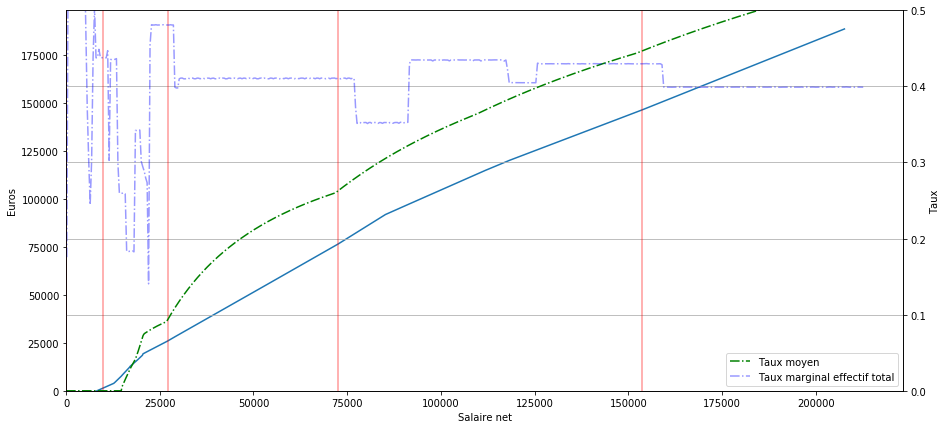

In [32]:
fig = plt.figure(figsize=(15,7))
smooth = 2
ax = fig.add_subplot(1,1,1) 
ax2 = ax.twinx()
ax.plot(rni, 
        salaire_super_brut- revenu_disponible, label = 'Impot total')
ax2.plot(rni,
        1-rates.average_rate(
                           impot_total_sur_le_revenu,revenu_disponible), linestyle = "-.", color = "g", label = "Taux moyen")

ax2.plot(salaire_net[1::smooth],
        1-rates.marginal_rate(
                           revenu_disponible,salaire_super_brut)[::smooth], linestyle = "-.", color = "b", label = "Taux marginal effectif total", alpha = 0.4)


for val in df_piecewize_scheame[2017]["Threshold"]: 
    plt.vlines(val, 0,0.5, color = 'r', alpha = .4)
ax.set_xlim(0); ax.set_ylim(0); ax2.set_ylim(0,.5); plt.legend(); plt.grid(); ax.set_xlabel("Salaire net"); ax2.set_ylabel("Taux") ; ax.set_ylabel("Euros")

On voit de manière assez étonnante que le taux moyen effectif est relativement stable le long de la distribution avec un taux effectif du salaire super-brut étant d'environ 30% du revenu disponible.  

Ces résultats sont à prendre avec précaution, une vérification des contisations sociales, abattements divers et variés s'appliquant entre le salaire super-brut et le salaire net sont peut être imprécis (les détails techniques concernant les cotisations sociales dépassent mon champ de compétence).  

Peut-être cela vous donne envie de vérifier cela, et de devenir contributeur OpenFisca si vous trouvez des formules à améliorer ?

## Gain fiscal au mariage

In [282]:
def switch_foyer_sum_to_menage(simulation, variable): #Une petite fonction pour agréger les variables de plusiseurs foyers fiscaux appartenant au même ménage.
    computed_variable = simulation.calculate(variable, period = "2016")
    projected_variable =  simulation.foyer_fiscal.project_on_first_person(computed_variable)
    summed_over_menage_variable = simulation.menage.sum(projected_variable)
    return summed_over_menage_variable

#### Couples Monoactifs

Un menage composé d'un couple monoactif de concubins sans enfant devrait payer le même impôt qu'un célibataires ayant le même salaire, vérifions celà en prenant un couple de concubins et comparons à un célibataire.

In [34]:
simulation_single = make_scenario(couple = False, mar_pacs=False,nombre_enfants=0,year = 2016, ax_variable_min=0, ax_variable_max=250000, salaire_de_base_conjoint=0).new_simulation()
simulation_couple = make_scenario(couple = True, mar_pacs=False,nombre_enfants=0,year = 2016, ax_variable_min=0, ax_variable_max=250000, salaire_de_base_conjoint=0).new_simulation()
simulation_couple_marpacs = make_scenario(couple = True, mar_pacs=True,nombre_enfants=0,year = 2016, ax_variable_min=0, ax_variable_max=250000, salaire_de_base_conjoint=0).new_simulation()

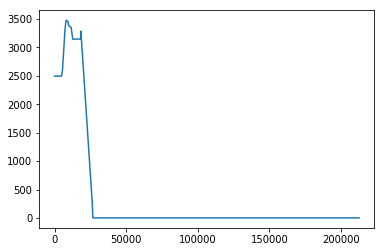

In [35]:
salaire_net = simulation_single.calculate_add("salaire_net", 2016)
plt.plot( salaire_net,
         simulation_couple.calculate("revenu_disponible", period = 2016) - simulation_single.calculate("revenu_disponible", period = 2016))

On voit bien qu'a l'exception des minimums sociaux qui dépendent de la structure du ménage, le revenu disponible est le même quand on sort de ces minimums. L'impôt est donc neutre entre les couples sans unions civile et les célibataires pour un même montant imposable total du ménage.

Pourtant il y a un gain notable à se marier ou se pacser dans le cadre des couples monoactifs (avec ou sans enfants), en effet le revenu mis au barème sera divisé par deux...

Text(0,0.5,'Gain fiscal au mariage')

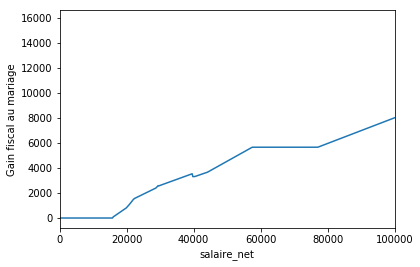

In [36]:
plt.figure()
plt.plot( salaire_net
    ,simulation_couple_marpacs.calculate("revenu_disponible", period = 2016) -simulation_couple.calculate("revenu_disponible", period = 2016) )
plt.xlim(0,10**5); plt.xlabel("salaire_net") ; plt.ylabel("Gain fiscal au mariage")

On peut également voir l'évolution de ce gain en fonction des années et des changement dans le barème. Les changements d'une anne sur l'autre sont du essentiellement à la décote et à la suppression de la première tranche de l'impôt sur le revenu.

(15000, 50000)

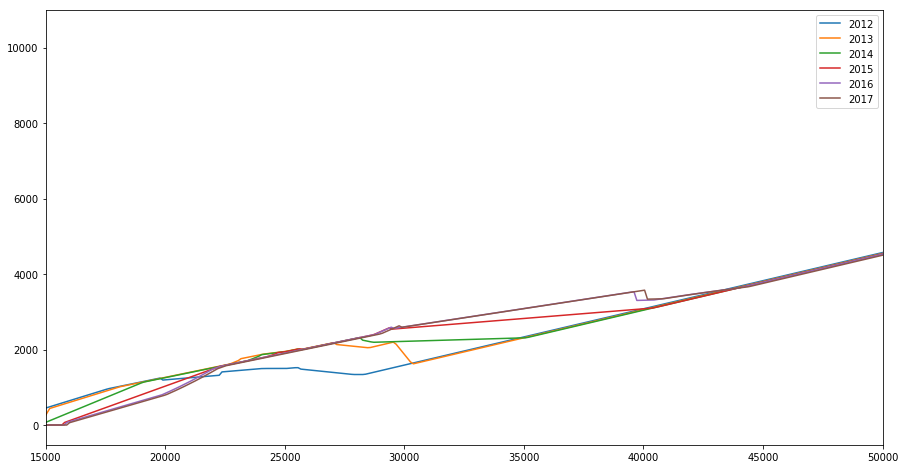

In [37]:
%matplotlib inline
plt.figure(figsize=(15,8))
for year in range(2012,2018):
    simulation_couple = make_scenario(couple = True, mar_pacs=False,nombre_enfants=0,year = year, ax_variable_min=0, ax_variable_max=150000, salaire_de_base_conjoint=0).new_simulation()
    simulation_couple_marpacs = make_scenario(couple = True, mar_pacs=True,nombre_enfants=0,year = year, ax_variable_min=0, ax_variable_max=150000, salaire_de_base_conjoint=0).new_simulation()
    salaire_net = simulation_couple.calculate_add("salaire_net", year)
    plt.plot( salaire_net[::2],
    simulation_couple_marpacs.calculate("revenu_disponible", period = year) -simulation_couple.calculate("revenu_disponible", period = year), label = year )
plt.legend(); plt.xlim(15000, 50000)

In [38]:
simulation_couple = make_scenario(couple = True, mar_pacs=False,nombre_enfants=0,year = 2016, ax_variable_min=15000, ax_variable_max=30000, salaire_de_base_conjoint=25000, count = 10).new_simulation()
simulation_couple.calculate("ip_net", 2016)
simulation_couple.calculate_add("salaire_net", 2016)

array([11676.004, 19460.002, 12973.339, 19460.002, 14270.667, 19460.002,
       15568.003, 19460.002, 16865.34 , 19460.002, 18162.664, 19460.002,
       19460.002, 19460.002, 20757.338, 19460.002, 22054.66 , 19460.002,
       23352.   , 19460.002], dtype=float32)

#### Couples Biactifs

CPU times: user 46.7 s, sys: 1.09 s, total: 47.8 s
Wall time: 51.8 s


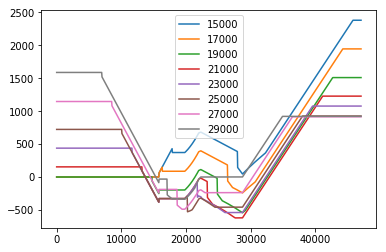

In [39]:
%%time
for salaire_de_base_conjoint in range(15000,30000, 2000):
    simulation_couple = make_scenario(couple = True, mar_pacs=False,nombre_enfants=0,year = 2016, ax_variable_min=0, ax_variable_max=60000, salaire_de_base_conjoint=salaire_de_base_conjoint).new_simulation()
    simulation_couple_marpacs = make_scenario(couple = True, mar_pacs=True,nombre_enfants=0,year = 2016, ax_variable_min=0, ax_variable_max=60000, salaire_de_base_conjoint=salaire_de_base_conjoint).new_simulation()
    salaire_net = simulation_couple.calculate_add("salaire_net", 2016)[::2]
    plt.plot(salaire_net, simulation_couple_marpacs.calculate("revenu_disponible", period = 2016) -simulation_couple.calculate("revenu_disponible", period = 2016),
             label= salaire_de_base_conjoint )
plt.legend()

Nous allons maintenant faire une simiulation plus complexes avec des `axes` `perpendiculaires`, qui permettent de simuler toutes le combinaisons de salaire femme/homme. Nous faisions une simulation sur 1000 ménages ordonné du plus pauvre au plus riche ayant des revenu salariaux entre 1000 et 200 000 euros. Nous allons ici passer à une simulation sur $1000^2$ ménages en faisant varier le salaire de chaque concubin entre 1000 et 200 000 euros, soit 1 million de simulations.

## Le plafond du quotient familial.

Forthcoming :-).

### Conclusion